<a href="https://colab.research.google.com/github/tabaraei/Data-Science-Toolkit/blob/master/Scikit-Learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook presents some typical procedures involved in the machine learning tasks, such as loading the dataset, data wrangling, preprocessing, modelling, and visualizations. You can refer to the [API Reference](https://scikit-learn.org/stable/modules/classes.html) and [User Guide](https://scikit-learn.org/stable/user_guide.html#user-guide) of scikit-learn for the available online documentation.

# Setting the enivironment

In order to access the latest scikit-learn release, consider running `!pip install --upgrade scikit-learn` (restart the runtime after running the command).

In [ ]:
%%capture
!pip install --upgrade scikit-learn

# 1- Dataset

Either looking for an artifical dataset generator or ready-to-load datasets, they are all available at [this link](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets) on the scikit-learn documentation.

## 1-1- Generated Datasets

Using the generators available in the scikit-learn documentation [here](https://scikit-learn.org/stable/modules/classes.html#samples-generator), we can easily define a toy dataset of our own choice with the required settings to begin the modelling. They can be imported using `from sklearn.datasets import make_FUNCTION_NAME`. Below, you can find some samples of dataset generatiors for different purposes.

### 1-1-1- Classification and Clustering Generators

These generators produce a matrix of features and corresponding discrete targets, either for _single label_ or _multilabel_ tasks. Also, for the information regarding Biclustering please refer to the [documentation](https://scikit-learn.org/stable/datasets/sample_generators.html#biclustering).

**1. Single-Label Generators**

- `make_blobs` creates _multiclass_ datasets by allocating each class __one or more__ normally-distributed clusters of points. It provides greater control regarding the centers and standard deviations of each cluster, and is used to demonstrate clustering.

- `make_classification` creates _multiclass_ datasets by allocating each class __one or more__ normally-distributed clusters of points. It specializes in introducing noise by way of: correlated, redundant and uninformative features; multiple Gaussian clusters per class; and linear transformations of the feature space.

- `make_gaussian_quantiles` divides a single Gaussian cluster into near-equal-size classes separated by concentric hyperspheres.

- `make_hastie_10_2` generates a similar binary, 10-dimensional problem.

- `make_circles` and `make_moons` generate 2d binary classification datasets that are challenging to certain algorithms (e.g. _centroid-based clustering_ or _linear classification_), including optional Gaussian noise. They are useful for visualization. `make_circles` produces Gaussian data with a spherical decision boundary for binary classification (a large circle containing a smaller circle in 2D), while `make_moons` produces two interleaving half circles.

**2. Multilabel Generators:**

`make_multilabel_classification` generates random samples with multiple labels, reflecting a bag of words drawn from a mixture of topics. The number of topics for each document is drawn from a Poisson distribution, and the topics themselves are drawn from a fixed random distribution. Similarly, the number of words is drawn from Poisson, with words drawn from a multinomial, where each topic defines a probability distribution over words. Simplifications with respect to true bag-of-words mixtures include:

- Per-topic word distributions are independently drawn, where in reality all would be affected by a sparse base distribution, and would be correlated.

- For a document generated from multiple topics, all topics are weighted equally in generating its bag of words.

- Documents without labels words at random, rather than from a base distribution.

Below, you can find some of the **single-label** generators for the classification and clustering tasks.

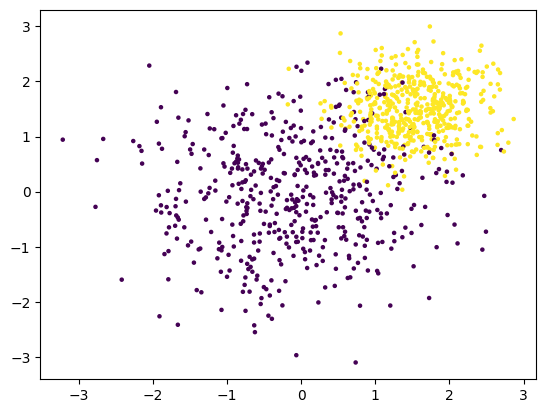

In [ ]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=1000, n_features=2, centers=[(0, 0), (1.5, 1.5)], cluster_std=[1, 0.5])
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

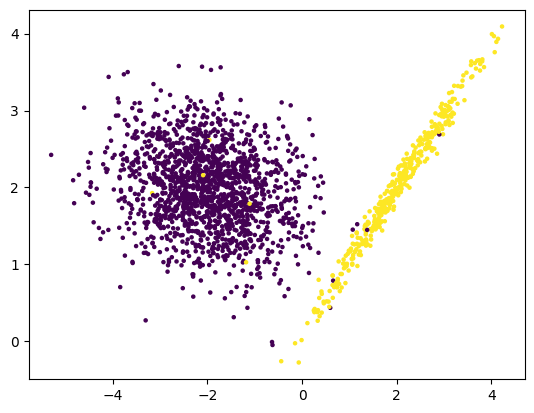

In [ ]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

X, y = make_classification(n_samples=2000, n_features=2, n_informative=2, n_redundant=0, n_classes=2, n_clusters_per_class=1, weights=[0.7, 0.1], class_sep=2, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

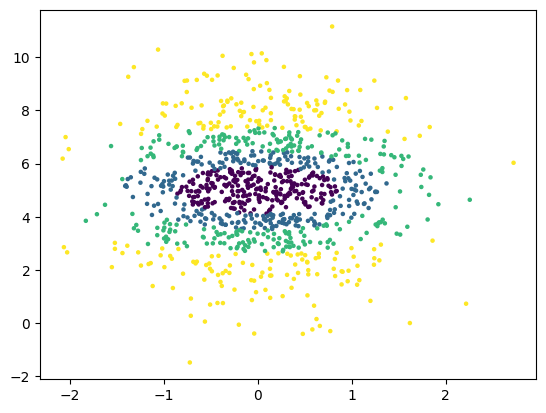

In [ ]:
from sklearn.datasets import make_gaussian_quantiles
import matplotlib.pyplot as plt

X, y = make_gaussian_quantiles(n_samples=1000, n_classes=4, n_features=2, mean=[0, 5], cov=[0.5, 4.0], random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

In [ ]:
from sklearn.datasets import make_hastie_10_2
import pandas as pd
import numpy as np

X, y = make_hastie_10_2(n_samples=12_000, random_state=1)
pd.DataFrame(np.c_[X, y]).head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,1.624345,-0.611756,-0.528172,-1.072969,0.865408,-2.301539,1.744812,-0.761207,0.319039,-0.249370,1.0
1,1.462108,-2.060141,-0.322417,-0.384054,1.133769,-1.099891,-0.172428,-0.877858,0.042214,0.582815,1.0
2,-1.100619,1.144724,0.901591,0.502494,0.900856,-0.683728,-0.122890,-0.935769,-0.267888,0.530355,-1.0
3,-0.691661,-0.396754,-0.687173,-0.845206,-0.671246,-0.012665,-1.117310,0.234416,1.659802,0.742044,-1.0
4,-0.191836,-0.887629,-0.747158,1.692455,0.050808,-0.636996,0.190915,2.100255,0.120159,0.617203,1.0


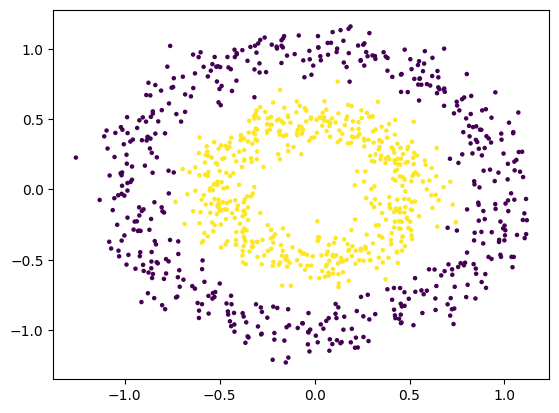

In [ ]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

X, y = make_circles(n_samples=1000, noise=0.1, factor=0.5, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

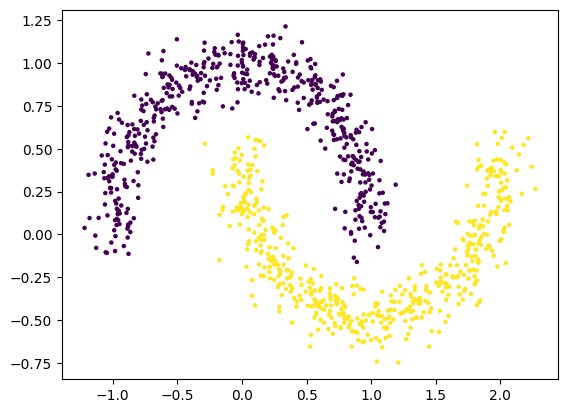

In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

### 1-1-2- Regression Generators

**1. Linear Relations Generator:**

- `make_regression` produces regression targets as an optionally-sparse random linear combination of random features, with noise. Its informative features may be uncorrelated, or low rank (few features account for most of the variance). Other regression generators generate functions deterministically from randomized features.

- `make_sparse_uncorrelated` produces a target as a linear combination of four features with fixed coefficients.

**2. Non-Linear Relations Generator:**

- `make_friedman1` is related by polynomial and sine transforms;
- `make_friedman2` includes feature multiplication and reciprocation;
- and `make_friedman3` is similar with an arctan transformation on the target.

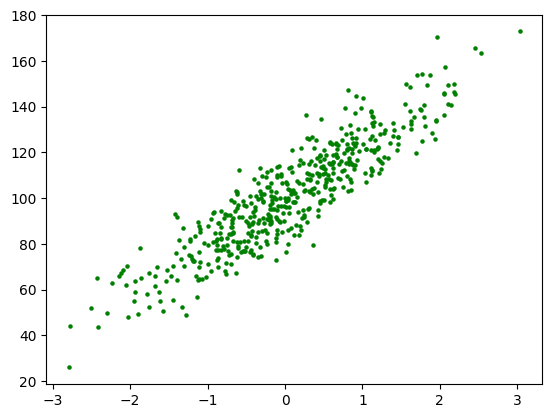

In [ ]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

X, y = make_regression(n_samples=500, n_features=1, bias=100, noise=10, random_state=1)
plt.scatter(X, y, c='green', s=5);

We can also use mathematical functions and random samples to generate data for the regression task:
- `np.random.rand(d0, d1, ..., dn)` creates an array of the given shape and populate it with random samples from a uniform distribution over [0, 1).
- `np.random.randn(d0, d1, ..., dn)` returns an array filled with random floats sampled from a univariate “normal” (Gaussian) distribution of mean 0 and variance 1. For random samples from the normal distribution with mean mu and standard deviation sigma, use `sigma * np.random.randn(...) + mu` instead.

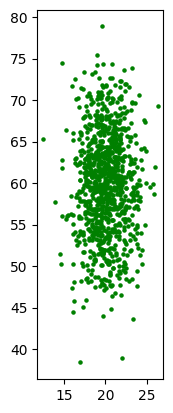

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mu = 20
sigma = 2
X = sigma * np.random.randn(1000, 1) + mu
y = (sigma * np.random.randn(1000, 1) + mu) * 3

plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(X, y, c='green', s=5);

Also, we can use the Numpy's `random` module to create our own _uniform_ or _normal_ distribution of values.

In [ ]:
import numpy as np

def regression_generator(n_samples=1000, mu=0, sigma=0.1, expr=None):
    # Force the X random samples within range [-1, 1]
    X = np.random.rand(n_samples) * 2 - 1
    y = X.copy()

    # Add some noise to y to make it a regression problem
    noise = np.random.normal(mu, sigma, n_samples)
    y += noise

    # apply a mathematical expression to the y values w.r.t. X
    if expr: y = eval(expr)

    return X, y

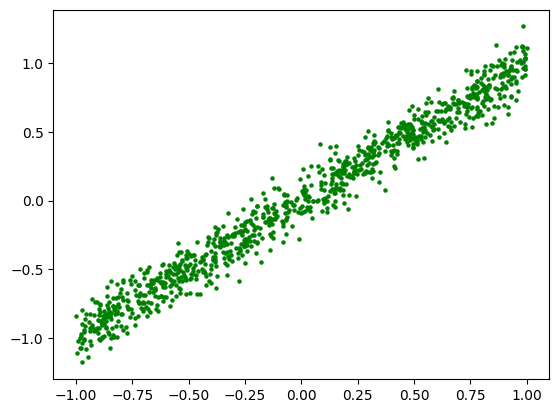

In [ ]:
import matplotlib.pyplot as plt

X, y = regression_generator()
plt.scatter(X, y, c='green', s=5);

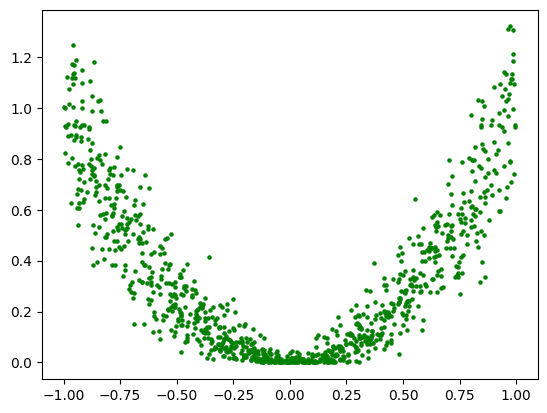

In [ ]:
import matplotlib.pyplot as plt

X, y = regression_generator(expr='y**2')
plt.scatter(X, y, c='green', s=5);

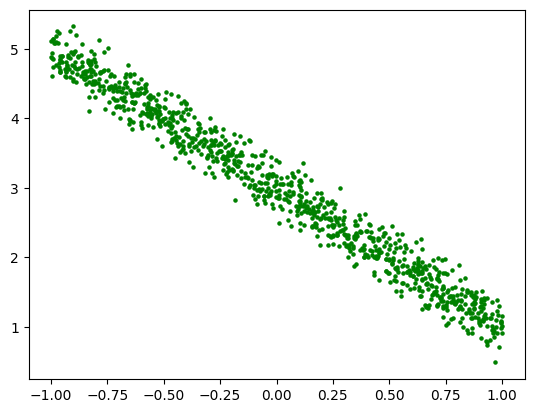

In [ ]:
import matplotlib.pyplot as plt

X, y = regression_generator(expr='-2*y + 3')
plt.scatter(X, y, c='green', s=5);

## 1-2- Dataset Loaders

The `sklearn.datasets` module includes utilities to load datasets, including methods to load and fetch popular reference datasets. Full list of datasets can be found [here](https://scikit-learn.org/stable/modules/classes.html#loaders).

### 1-2-1- scikit-learn Reference Datasets

They can be easily accessed by either:
- `from sklearn.datasets import fetch_DATASET_NAME`
- `from sklearn.datasets import load_DATASET_NAME`

In [ ]:
from sklearn.datasets import load_diabetes

data = load_diabetes()
print(data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [ ]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True, as_frame=True)
X.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930


#### 1-2-1-1- Classification Datasets

In [ ]:
from sklearn.datasets import load_breast_cancer, load_digits, load_iris, load_wine

X, y = load_breast_cancer(return_X_y=True)
X, y = load_digits(return_X_y=True)
X, y = load_iris(return_X_y=True)
X, y = load_wine(return_X_y=True)

#### 1-2-1-2 Regression Datasets

In [ ]:
from sklearn.datasets import load_diabetes, fetch_california_housing

X, y = load_diabetes(return_X_y=True)
X, y = fetch_california_housing(return_X_y=True)

### 1-2-2- OpenML Reference Datasets

Using `datasets.fetch_openml` along with the dataset name/id and its version, we can easily get access to numerous public datasets available on [OpenML](https://www.openml.org/search?type=data&sort=runs&status=active) for different tasks.

In [ ]:
from sklearn.datasets import fetch_openml

train_data = fetch_openml(name='adult', version=2, as_frame=True, parser='auto')
train_df = train_data.frame

print(train_data.DESCR)
train_df.head(3)

**Author**: Ronny Kohavi and Barry Becker  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/Adult) - 1996  
**Please cite**: Ron Kohavi, "Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid", Proceedings of the Second International Conference on Knowledge Discovery and Data Mining, 1996  

Prediction task is to determine whether a person makes over 50K a year. Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))

This is the original version from the UCI repository, with training and test sets merged.

### Variable description

Variables are all self-explanatory except __fnlwgt__. This is a proxy for the demographic background of the people: "People with similar demographic characteristics should have similar weights". This similarity-statement is not transferable across the 51 different states.

Description f

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K


# 2- Data Wrangling

In [ ]:
# check whether they are an indicator of the target, or they can be easily removed if they do not provide any information.
sns.countplot(data=train_df, x='feature', hue='target', palette='RdBu')
plt.xticks(rotation=90);

# 3- Preprocessing

Let's consider using an unpreprocessed dataset take from the Seaborn's datasets, and clean the dataset accordingly.

In [56]:
import seaborn as sns

train_df = sns.load_dataset('titanic')
X = train_df.drop(['survived'], axis='columns')
y = train_df['survived']
X.head(3)

,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True


## 3-1- Data Types

In [58]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   pclass       891 non-null    int64   
 1   sex          891 non-null    object  
 2   age          714 non-null    float64 
 3   sibsp        891 non-null    int64   
 4   parch        891 non-null    int64   
 5   fare         891 non-null    float64 
 6   embarked     889 non-null    object  
 7   class        891 non-null    category
 8   who          891 non-null    object  
 9   adult_male   891 non-null    int64   
 10  deck         203 non-null    category
 11  embark_town  889 non-null    object  
 12  alive        891 non-null    int64   
 13  alone        891 non-null    int64   
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.9+ KB


In [57]:
X['alone'] = X['alone'].astype(int)
X['adult_male'] = X['adult_male'].astype(int)
X['alive'] = X['alive'].map({'yes': 1, 'no': 0})
X.dtypes

pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male        int64
deck           category
embark_town      object
alive             int64
alone             int64
dtype: object

In [59]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(categorical_cols)

numerical_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()
print(numerical_cols)

['sex', 'embarked', 'class', 'who', 'deck', 'embark_town']
['pclass', 'age', 'sibsp', 'parch', 'fare', 'adult_male', 'alive', 'alone']


## 3-1- Feature Selection

Throughout our analysis, we will keep our main focus on providing preprocessing methods to satisfy the modelling performance at its best. Some of the __features__ in our dataset should be __immediately removed__ due to their __irrelevance to our analysis__.

It is worthy to note that, these assumptions should be later tested with respect to our baseline model, and to be checked if they can improve the performance of our model or not.

The process of _feature selection_ could be also automized using the `sklearn.feature_selection` module, where there are a variety of methods to apply to our dataset __to find the most promising features__.

For example, in the `titanic` dataset, it is clear that the `alive` column is a duplication of our target variable, and should be immediately removed from our dataset. Otherwise, it might cause _data leakage_.

In [25]:
X.drop(columns=['alive'], inplace=True, errors='ignore')
X.head(3)

,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,False
1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,False
2,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,True


## 3-2- Duplicatied Rows

We can check if a dataset contains any duplicated rows as below, and check whether their **according label** is different or not:

In [26]:
duplications_df = X[X.duplicated(keep=False)].sort_values(by=list(X.columns))
duplications_df.join(y).head(4)

,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone,survived
369,1,female,24.0,0,0,69.3000,C,First,woman,False,B,Cherbourg,True,1
641,1,female,24.0,0,0,69.3000,C,First,woman,False,B,Cherbourg,True,1
64,1,male,NaN,0,0,27.7208,C,First,man,True,NaN,Cherbourg,True,0
295,1,male,NaN,0,0,27.7208,C,First,man,True,NaN,Cherbourg,True,0


We can remove such rows using the `drop_duplicates` function from Pandas, which also offers removing based on a _subset of features_ rather than _all_ the columns:

In [27]:
train_df.drop_duplicates(inplace=True)
train_df.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True


## 3-3- Missing Values

While performing machine learning tasks, our dataset cannot contain `Nan` or any other type of missing values. We should check if our dataset contains these values.

In [28]:
cols_with_missing = [col for col in train_df.columns if train_df[col].isnull().any()]
print(cols_with_missing)

missing_rows_df = train_df[train_df.isnull().any(axis=1)]
missing_rows_df.head(3)

['age', 'embarked', 'deck', 'embark_town']


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.250,S,Third,man,True,NaN,Southampton,no,False
2,1,3,female,26.0,0,0,7.925,S,Third,woman,False,NaN,Southampton,yes,True
4,0,3,male,35.0,0,0,8.050,S,Third,man,True,NaN,Southampton,no,True


There are a variety of techniques such as below, to deal with these values:

1. __Ignore the Missing Values__

2. __Fill the Missing Values__

### 3-3-1- Ignore the Missing Values

This strategy is mostly used if the dataset size is very big and the number of missing values are small, while losing them will not affect our modelling process. We can ignore the missing values either by removing the associated **rows** or **columns**.

An example of removing the missing rows has been provided below. It is clear that this is not a good strategy in most cases, as we will lose a lot of information.

In [31]:
before_shape = train_df.shape
train_df_preprocessed = train_df.dropna(axis=0)
after_shape = train_df_preprocessed.shape

print(f'Rows with missing values count: {len(missing_rows_df)}')
print(f'DataFrame shape before removing the rows with missing values: {before_shape}')
print(f'DataFrame shape after removing the rows with missing values: {after_shape}')

Rows with missing values count: 603
DataFrame shape before removing the rows with missing values: (784, 15)
DataFrame shape after removing the rows with missing values: (181, 15)


Alternatively, we can remove features with missing values if they do not add any value to our analysis.

In [30]:
before_shape = train_df.shape
train_df_preprocessed = train_df.dropna(axis=1)
after_shape = train_df_preprocessed.shape

print(f'Features with missing values count: {len(cols_with_missing)}')
print(f'DataFrame shape before removing the features with missing values: {before_shape}')
print(f'DataFrame shape after removing the features with missing values: {after_shape}')

Features with missing values count: 4
DataFrame shape before removing the features with missing values: (784, 15)
DataFrame shape after removing the features with missing values: (784, 11)


### 3-3-2- Fill the Missing Values

There are some techniques to fill the missing values using the most frequent or the average values of the other samples in that feature. For example, using scikit-learn's `SimpleImputer` preprocessing tool, we can fill the missing values for our __numerical__ features using the average values in that column, while for __categorical__ features we utilize the most frequent values.

In [ ]:
from sklearn.impute import SimpleImputer

numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

## 3-4- Scaling & Encoding

While analyzing the numerical and categorical features of our dataset, we have to perform some preprocessing steps to our data. For the __numerical__ features, we will use the `MinMaxScaler` for now, which transforms the range of our values to range [0, 1]. For the __categorical__ features, we will apply a `OneHotEncoder` which generates new columns for each value of the categorical feature.

### 3-4-1- Numerical Features

Numerical columns should be taken care of their range of values, and the effect that they can have if they are not normalized. Using the `.describe()` function on a DataFrame, we can get some statistical quantities computed on our __numerical__ columns (by default it accepts only the numerical columns), where we can get an inspiration of what are the variance, average, and the range of our numerical features.

In [64]:
X[numerical_cols].describe()

,pclass,age,sibsp,parch,fare,adult_male,alive,alone
count,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208,0.602694,0.383838,0.602694
std,0.836071,14.526497,1.102743,0.806057,49.693429,0.489615,0.486592,0.489615
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,0.000000,1.000000
75%,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000,1.000000,1.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000


Analyzing the numerical columns, it is evident that one critical step during our modelling process should be `normalizing` our numerical values, since they range on different scales. Also, utilizing techniques such as `regularization` might be a good idea to overcome the features which do not provide much value to our modelling.

### 3-4-2- Categorical Features

In order to train our model, we need to pass feature vectors of numerical entities, such that it does not contain any categorical objects. To overcome this issue, we can consider to use some techniques such as `OneHotEncoder` and `OrdinalEncoder` depending on our category cardinality and progression.

- If there is a _logical progression_ in our category unique values (e.g., small, medium, large) we shall use `OrdinalEncoder`
- If we have _low cardinality_ columns, `OneHotEncoder` can be considered.

In [66]:
X[categorical_cols].head(3)

,sex,embarked,class,who,deck,embark_town
0,male,S,Third,man,NaN,Southampton
1,female,C,First,woman,C,Cherbourg
2,female,S,Third,woman,NaN,Southampton


Let's explore the cardinality of these categorical columns first, and the unique values they accept.

In [67]:
X[categorical_cols].nunique()

sex            2
embarked       3
class          3
who            3
deck           7
embark_town    3
dtype: int64

For each of the columns, we can either use the `unique()` function to access their unique values, or `value_counts()` to also get their according frequency.

In [81]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

unique_values = [X[categorical_cols][col].value_counts().to_dict() for col in categorical_cols]

pd.DataFrame({
    'Unique Values': unique_values
}, index=X[categorical_cols].columns)

,Unique Values
sex,"{'male': 577, 'female': 314}"
embarked,"{'S': 644, 'C': 168, 'Q': 77}"
class,"{'Third': 491, 'First': 216, 'Second': 184}"
who,"{'man': 537, 'woman': 271, 'child': 83}"
deck,"{'C': 59, 'B': 47, 'D': 33, 'E': 32, 'A': 15, 'F': 13, 'G': 4}"
embark_town,"{'Southampton': 644, 'Cherbourg': 168, 'Queenstown': 77}"


## Preprocessing

### 1- Handling categorical features

In [ ]:
categories = X_train_cls.select_dtypes(include='category')
low_cardinality_cols = [col for col in X_train_cls.columns if X_train_cls[col].nunique() < 7]
high_cardinality_cols = list(set(categories) - set(low_cardinality_cols))

low_cardinality_cols, high_cardinality_cols

(['relationship', 'race', 'sex'],
 ['workclass', 'education', 'marital-status', 'native-country', 'occupation'])

#### 1-1- Ordinal Encoder

In [ ]:
X_train_cls[high_cardinality_cols].head(3)

,workclass,education,marital-status,native-country,occupation
917,Private,Some-college,Married-civ-spouse,United-States,Machine-op-inspct
28178,Private,Some-college,Married-civ-spouse,United-States,Sales
46975,Private,HS-grad,Married-civ-spouse,United-States,Handlers-cleaners


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
X_train_cls[high_cardinality_cols] = encoder.fit_transform(X_train_cls[high_cardinality_cols].copy())
X_test_cls[high_cardinality_cols] = encoder.transform(X_test_cls[high_cardinality_cols].copy())

In [ ]:
X_train_cls[high_cardinality_cols].head(3)

,workclass,education,marital-status,native-country,occupation
917,2.0,15.0,2.0,38.0,6.0
28178,2.0,15.0,2.0,38.0,11.0
46975,2.0,11.0,2.0,38.0,5.0


#### 1-2- One Hot Encoder

In [ ]:
X_train_cls[low_cardinality_cols].head(3)

,relationship,race,sex
917,Husband,White,Male
28178,Husband,White,Male
46975,Husband,White,Male


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# get dataframe of one-hot encoding on low cardinality columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
one_hot_train = pd.DataFrame(encoder.fit_transform(X_train_cls[low_cardinality_cols]))
one_hot_test = pd.DataFrame(encoder.transform(X_test_cls[low_cardinality_cols]))

# fix indices of one-hot encoder before merging
one_hot_train.index = X_train_cls.index
one_hot_test.index = X_test_cls.index

# assign column names
one_hot_train.columns = encoder.get_feature_names()
one_hot_test.columns = encoder.get_feature_names()

# Remove categorical columns
X_train_cls = X_train_cls.drop(low_cardinality_cols, axis=1)
X_test_cls = X_test_cls.drop(low_cardinality_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train_cls = pd.concat([X_train_cls, one_hot_train], axis=1)
X_test_cls = pd.concat([X_test_cls, one_hot_test], axis=1)

In [ ]:
one_hot_train.head(3)

,x0_Husband,x0_Not-in-family,x0_Other-relative,x0_Own-child,x0_Unmarried,x0_Wife,x1_Amer-Indian-Eskimo,x1_Asian-Pac-Islander,x1_Black,x1_Other,x1_White,x2_Female,x2_Male
917,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
28178,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
46975,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


#### 1-3- Remove Categorical features and replace with preprocessed ones

### 2- Numeric features

Using [drawdata](https://drawdata.xyz/) website, you can easily draw points on the flow, and download the corresponding `csv` file to play with.

#### Scaling

In order to normalize the numerical columns, there are various strategies to be utilized:
- `StandardScaler`, which standardizes features by forcing zero mean and scaling to unit variance as `z = (x - u) / s`.
- `QuantileTransformer`, which is less affected by the outliers and better transforms the data based on quantiles.
- TO BE ADDED: PolynomialFeatures()

In [ ]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

# variants of scaler can be easily substituted, such as "QuantileTransformer"
scaler = StandardScaler()
X, _ = load_wine(return_X_y=True)
X_scaled = scaler.fit_transform(X)

#### Imputer (missing values)

Transformers for missing value imputation can be found [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute). Such as:
- `SimpleImputer`, _univariate_ imputer for completing missing values with simple strategies. Replaces missing values using a descriptive statistic (e.g. mean, median, or most frequent) along each column, or using a constant value.
- `IterativeImputer`, _multivariate_ imputer that estimates each feature from all the others.
- `MissingIndicator`, binary indicators for missing values.
- `KNNImputer`, imputation for completing missing values using k-Nearest Neighbors. Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set (two samples are close if the features that neither is missing are close).

In [ ]:
from sklearn.datasets import load_wine
from sklearn.impute import SimpleImputer, KNNImputer

imputer = SimpleImputer()
X, _ = load_wine(return_X_y=True)
X_scaled = imputer.fit_transform(X)

# 4- Model Training

Train Test Split

In [ ]:
y_cls = cls_dataframe['class']
X_cls = cls_dataframe.drop(['class'], axis='columns')

In [ ]:
from sklearn.model_selection import train_test_split

X_train_reg, X_test_reg, y_train_reg, y_test_reg = \
    train_test_split(X_reg, y_reg, random_state=1, test_size=0.1)

### Baseline Models

Basically, in model prediction, we assume that we have a dataset divided into two subsets:
- `X` is our feature set, which can contain categorical, numerical, boolean, and any type of value used in prediction
- `y` is our target set, which defines the desired predicted values

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y=True)
load_diabetes(as_frame=True).frame.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0


We should also consider splitting these sets into _training_ and _test_ sets, in order to divide the evaluation phase from our learning phase.
There are several strategies to achieve this as defined [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection), and also a nice visualization of these methods can be seen [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py). Here, we will stick to the common `train_test_split` function:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Then, we need to create our _model object_, which can be chosen among a variety of methods for the selected task. Since the internal API of all these objects is the same, we simply train the model by `X_train` and `y_train` using `.fit(X_train, y_train)`, and we further use the model object for predictions on the _test dataset_ using `.predict(X_test)`.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

# model can be simply substituted with another model, such as "LinearRegression"
model = KNeighborsRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model

KNeighborsRegressor()

If the model is not shown as a diagram above, consider activating the diagram display to see the visualized model.

In [ ]:
from sklearn import set_config

set_config(display='diagram')

### Pipeline

Sometimes, the prediction can be skewed in favour of some axes if our features in `X` are not normalized and they lie toward the widest range of values. It will force feature space vector along one direction, and it is necessary to follow some normalization steps to avoid this situation. In these cases, we want to expand the idea of _Model_ to a _Pipeline_ where everything inside this box is considered as the model. This notion also allows our test set to have the same preprocessing steps, and we can easily use the `.fit` and `.predict` to train our model in the pipeline. Pipeline, is a **list of tuples**, where each tuple defines the step taken in the `('name', object)` format .

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('model', KNeighborsRegressor())
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
pipe

Pipeline(steps=[('scaling', StandardScaler()),
                ('model', KNeighborsRegressor())])

### GridSearchCV

For each model, we might have to set several hyperparameters such that they best fit our data. It might be a time-consuming task to manually set and try different combinations of these parameters to find the best match. Using `GridSearchCV`, we perform a search on the defined values for our hyperparameters, while applying internal cross-validation at the same time. This method can be used with `.fit` and `.predict` as well.
The `estimator` attribute expects a model or pipeline, and the `param_grid` attribute expects a dictionary of all the desired params to be checked according to the define values. Note that we apply this on the original `X` and `y`, since it automatically applies cross-validation. There are also another hyperparameter optimizers defined [here](https://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers).

In [ ]:
pipe.get_params()

{'memory': None,
 'steps': [('scaling', StandardScaler()), ('model', KNeighborsRegressor())],
 'verbose': False,
 'scaling': StandardScaler(),
 'model': KNeighborsRegressor(),
 'scaling__copy': True,
 'scaling__with_mean': True,
 'scaling__with_std': True,
 'model__algorithm': 'auto',
 'model__leaf_size': 30,
 'model__metric': 'minkowski',
 'model__metric_params': None,
 'model__n_jobs': None,
 'model__n_neighbors': 5,
 'model__p': 2,
 'model__weights': 'uniform'}

In [ ]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

grid = GridSearchCV(
    estimator=pipe,
    param_grid={'model__n_neighbors': range(1,5)},
    cv=3
)
grid.fit(X, y)
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004440,0.002448,0.005789,0.003455,1,{'model__n_neighbors': 1},0.105976,0.124092,-0.158523,0.023849,0.129168,4
1,0.002546,0.000058,0.003248,0.000104,2,{'model__n_neighbors': 2},0.268889,0.339379,0.264563,0.290944,0.034295,3
2,0.002581,0.000090,0.003354,0.000182,3,{'model__n_neighbors': 3},0.333057,0.382744,0.356899,0.357567,0.020290,2
3,0.004172,0.002058,0.006057,0.003243,4,{'model__n_neighbors': 4},0.342407,0.404701,0.409910,0.385673,0.030668,1


### Post-Processing

These methods can be applied once our model has been trained in order to modify the outcomes and get the best results.

### 4-1- Meta Estimators

In some cases, it's a good idea to combine multiple estimators together and associating a weight to each of them, such that the decision is taken based on the `VotingClassifier`. However, this a post-processing stem, after the result by models are produced.

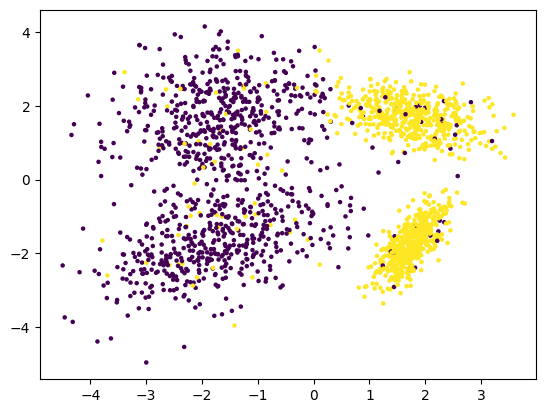

In [ ]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

X, y = make_classification(n_samples=2000, n_features=2, n_redundant=0, random_state=21, class_sep=1.75, flip_y=0.1)
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, s=5);

In [ ]:
import numpy as np

def make_plots():
    X_new = np.concatenate([
        np.random.uniform(np.min(X[:, 0]), np.max(X[:, 0]), (20000, 1)),
        np.random.uniform(np.min(X[:, 1]), np.max(X[:, 1]), (20000, 1))
    ], axis=1)
    plt.figure(figsize=(16, 4))
    plt.subplot(141)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
    plt.title("original data")
    plt.subplot(142)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf1.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens1")
    plt.subplot(143)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf2.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens2")
    plt.subplot(144)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf3.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens3");

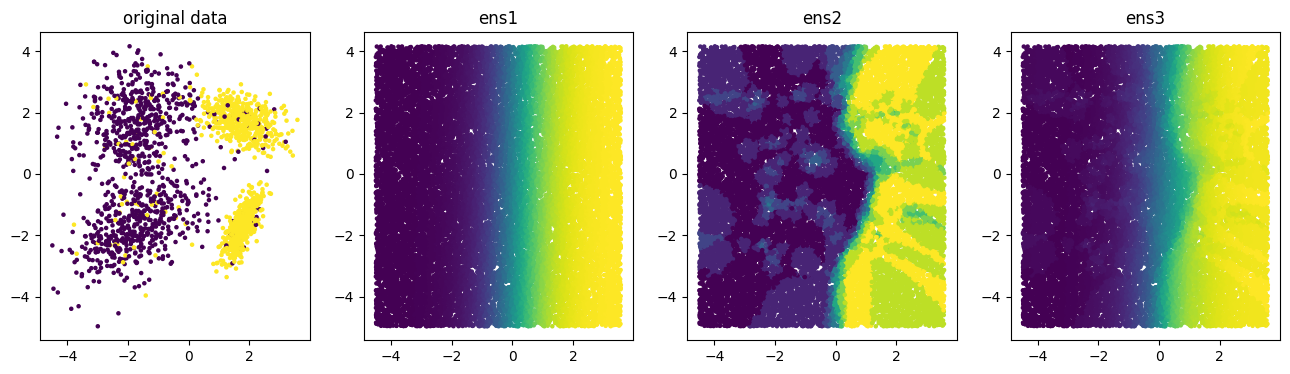

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression().fit(X, y)
clf2 = KNeighborsClassifier(n_neighbors=10).fit(X, y)
clf3 = VotingClassifier(estimators=[('clf1', clf1), ('clf2', clf2)], voting='soft', weights=[10.5, 2.5]).fit(X, y)

make_plots()

### 4-2- Thresholder

The thresholder can help tweak recall and precision of a model by moving the threshold value of predict_proba, and it's mostly applied on binary classification. Commonly this threshold is set at 0.5 for two classes. This meta-model can decorate an estimator with two classes such that the threshold moves. Full description of the related `scikit-lego` methods can be found [here](https://scikit-lego.netlify.app/meta.html).

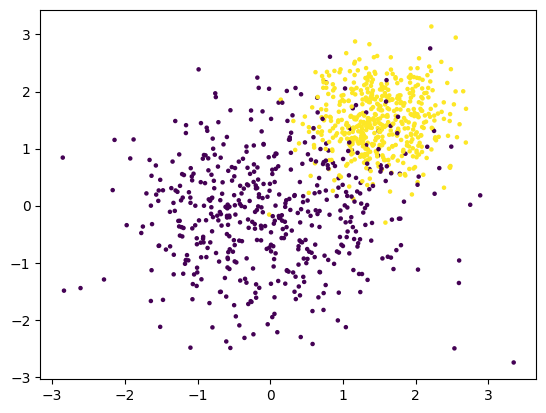

In [ ]:
import matplotlib.pylab as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(1000, centers=[(0, 0), (1.5, 1.5)], cluster_std=[1, 0.5])
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

In [ ]:
%%capture
!pip install scikit-lego

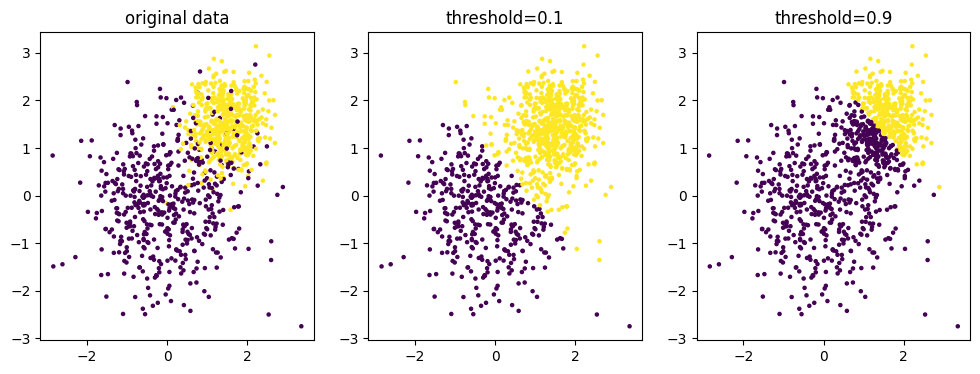

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklego.meta import Thresholder

m1 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1).fit(X, y)
m2 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.9).fit(X, y)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
plt.title("original data")
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=m1.predict(X), s=5)
plt.title("threshold=0.1")
plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c=m2.predict(X), s=5)
plt.title("threshold=0.9");

### 4-3- GroupedPredictor

Consider that instead of having one general model on our dataset, we train different models for each category of our choice all along each other. For example, instead of applying one-hot-encoding to our categorical column, we can have individual models for each category. In this case, according to the category that our new data point belongs, we decide to predict its corresponding target value using a specific model.

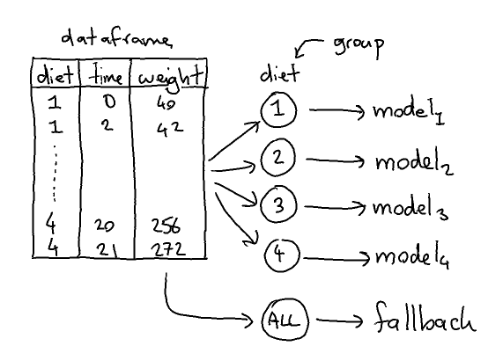

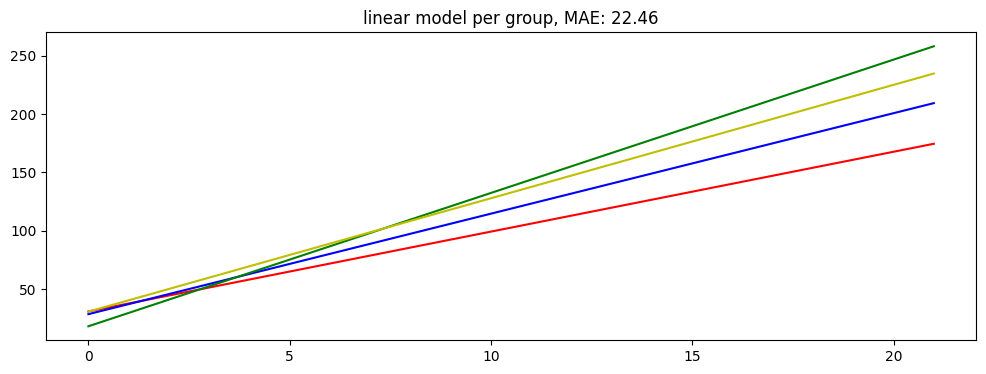

In [ ]:
from sklego.datasets import load_chicken
from sklearn.linear_model import LinearRegression
from sklego.meta import GroupedPredictor
from sklearn.metrics import mean_absolute_error
import matplotlib.pylab as plt
import numpy as np

df = load_chicken(as_frame=True)
X = df[['diet', 'time']]
y = df['weight']

model = GroupedPredictor(LinearRegression(), groups=["diet"])
model.fit(X, y)
metric_df = df[['diet', 'time', 'weight']].assign(pred=lambda d: model.predict(d[['diet', 'time']]))
metric = mean_absolute_error(metric_df['weight'], metric_df['pred'])
plt.figure(figsize=(12, 4))
# plt.scatter(df['time'], df['weight'])
for i in [1, 2, 3, 4]:
    pltr = metric_df[['time', 'diet', 'pred']].drop_duplicates().loc[lambda d: d['diet'] == i]
    plt.plot(pltr['time'], pltr['pred'], color='.rbgy'[i])
plt.title(f"linear model per group, MAE: {np.round(metric, 2)}");

## 5- Evaluation

Whether we are using `GridSearchCV` or any other strategy to find the best combination of hyperparameters along with the proper model selection regarding our task, we will evaluate and compare the different models based on a _metric_. A variety of metrics are predefined [here](https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).

### 5-1- Classification Metrics

There are different metrics to measure the classification results, such as:
- `accuracy_score`: Whether the _predicted_ labels exactly match the _true_ labels.
- `recall_score`: The ability of the classifier to find _all the positive samples_ (`TP / (TP + FN)`).
- `precision_score`: The ability of the classifier _not to label as positive_ for a sample that is negative (`TP / (TP + FP)`).


In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score

X, y = load_breast_cancer(return_X_y=True)
model = LogisticRegression(max_iter=3000).fit(X, y)
y_pred = model.predict(X)

# note that the metrics are applied to the training data, not the test data
accuracy_score(y, y_pred), recall_score(y, y_pred), precision_score(y, y_pred)

(0.9578207381370826, 0.9747899159663865, 0.9586776859504132)

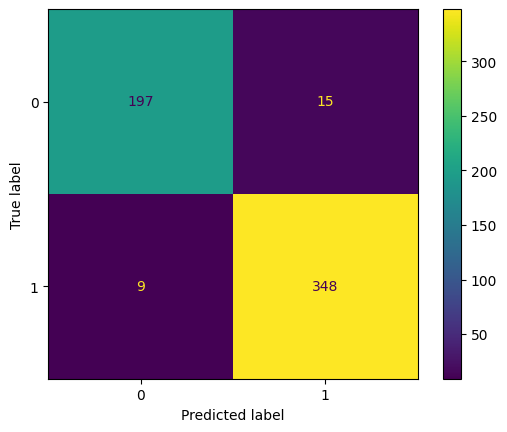

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot();

We have scenarios where making mistakes during the prediction toward either false positive (FP) or false negative (FN) might influence the performance of our model. For example, in case of cancer prediction or fraud detection, we might have imbalanced datasets that require higher weight associated with the positive classes, because there are fewer cases with a `True` value and they denote a more sensitive group. In such scenarios, we would prefer optimizing the __recall__ measure rather than other metrics.

The following cell represents a hyperparameter optimization such as `GridSearchCV`, where we assign a higher weight ratio to the positive class using `class_weight` parameter, as well as defining our own new metric to be calculated:

In [ ]:
def min_recall_precision(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import pandas as pd
import numpy as np

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=5000),
    param_grid={'class_weight': [{0:1, 1:w} for w in np.linspace(1, 20, 30)]},
    scoring={
        'recall': make_scorer(recall_score),
        'precision': make_scorer(precision_score),
        'min_both': make_scorer(min_recall_precision)
    },
    refit='min_both', # scorer used to find the best params refitting the model
    return_train_score=True,
    cv=5,
    n_jobs=-1
)
grid.fit(X, y)
# y_pred = grid.best_estimator_.predict(X)

metrics_df = pd.DataFrame(grid.cv_results_)
metrics_df.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,...,mean_test_min_both,std_test_min_both,rank_test_min_both,split0_train_min_both,split1_train_min_both,split2_train_min_both,split3_train_min_both,split4_train_min_both,mean_train_min_both,std_train_min_both
0,0.005606,0.001035,0.007405,0.002388,"{0: 1, 1: 1.0}","{'class_weight': {0: 1, 1: 1.0}}",0.9,0.9,0.8,0.7,...,0.765734,0.092200,14,0.92500,0.950000,0.951220,0.951220,0.875000,0.930488,0.029494
1,0.005325,0.000754,0.006674,0.000094,"{0: 1, 1: 1.6551724137931034}","{'class_weight': {0: 1, 1: 1.6551724137931034}}",1.0,0.9,0.9,0.8,...,0.770303,0.091079,13,0.97561,0.951220,0.930233,0.952381,0.952381,0.952365,0.014363
2,0.005558,0.000328,0.007438,0.001462,"{0: 1, 1: 2.310344827586207}","{'class_weight': {0: 1, 1: 2.310344827586207}}",1.0,0.9,0.9,0.8,...,0.790303,0.105277,1,0.97561,0.928571,0.909091,0.930233,0.930233,0.934747,0.021940


The plot below is able to show the effect of hyperparameter exploration on the `class_weight` parameter defined in our search, where for different values ranging within `np.linspace(1, 20, 30)` we can see their according effect on the metrics defined.

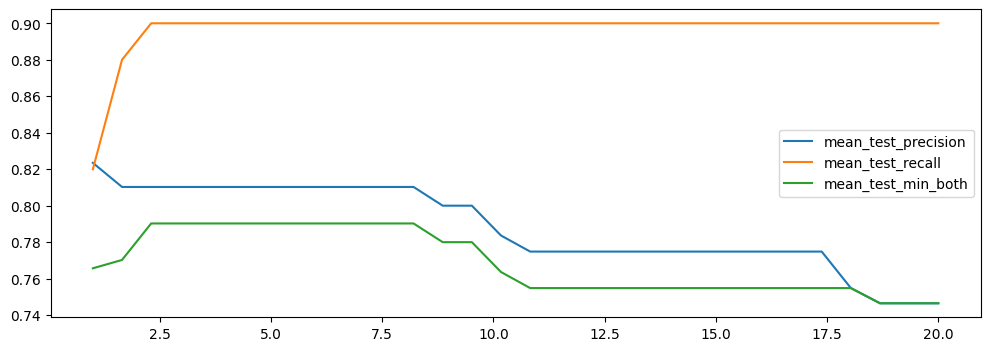

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for score in ['mean_test_precision', 'mean_test_recall', 'mean_test_min_both']:
    plt.plot([_[1] for _ in metrics_df['param_class_weight']], metrics_df[score], label=score)
plt.legend();

### 5-2- Regression Metrics

Using a rather simple scatter plot, we can see if there is a positive correlation between the predicted values and the desired values:

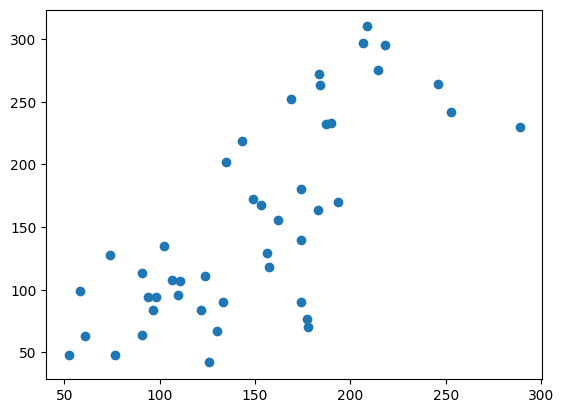

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_pred, y_test)

### 1- Regression

#### 1-1- Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

X, y = X_train_reg, y_train_reg
clf = LinearRegression()
clf.fit(X, y)

LinearRegression()

#### 1-2- Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

X, y = X_train_reg, y_train_reg
clf = LogisticRegression(random_state=0, max_iter=1000)
clf.fit(X, y)

LogisticRegression(max_iter=1000, random_state=0)

#### 1-3- Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X, y = X_train_reg, y_train_reg
clf = RandomForestRegressor(n_estimators=100, random_state=0)
clf.fit(X, y)

RandomForestRegressor(random_state=0)

#### 1-3- XGBoost Regressor

In [ ]:
from xgboost import XGBRegressor

X, y = X_train_reg, y_train_reg
clf = XGBRegressor(n_estimators=500, learning_rate=0.05, n_jobs=4, random_state=0)
clf.fit(X, y, early_stopping_rounds=5,
             eval_set=[(X_test_reg, y_test_reg)],
             verbose=False)

[16:02:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.05, n_estimators=500, n_jobs=4)

### 2- Classification

#### 2-1- Desicion Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

X, y = X_train_cls.select_dtypes(exclude='category'), y_train_cls
clf = DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier()

### 3- Model features

In [ ]:
clf.__class__.__name__

'DecisionTreeClassifier'

## Evaluation

Predict and evaluate model performance on a model. See a list of metrics [here](https://scikit-learn.org/stable/modules/model_evaluation.html).

### 1- Regression

In [ ]:
X, y, X_test, y_test = X_train_reg, y_train_reg, X_test_reg, y_test_reg
clf = LinearRegression()
clf.fit(X, y)

LinearRegression()

In [ ]:
y_pred = clf.predict(X_test)
y_pred[:5]

array([122.41932407, 111.48365055, 184.18558652,  68.52087272,
       171.44221745])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

MAE = mean_absolute_error(y_test, y_pred).round()
MSE = mean_squared_error(y_test, y_pred).round()

MAE, MSE

(43.0, 3320.0)

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_absolute_error') * -1

array([40.93764884, 48.2289054 , 46.57700111, 45.73373047, 43.7460327 ])

### 2- Classification

In [ ]:
X, y, X_test, y_test = X_train_cls, y_train_cls, X_test_cls, y_test_cls
clf = DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier()

In [ ]:
y_pred = clf.predict(X_test)
y_pred[:5]

array(['<=50K', '<=50K', '<=50K', '<=50K', '<=50K'], dtype=object)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(y_test, y_pred).round(3)  # or: clf.score(X_test, y_test)
precision = precision_score(y_test, y_pred, pos_label='>50K').round(3)
recall = recall_score(y_test, y_pred, pos_label='>50K').round(3)

accuracy, precision, recall

(0.801, 0.592, 0.633)

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(DecisionTreeClassifier(), X, y, cv=5, scoring='accuracy')

array([0.81044226, 0.81056511, 0.80614251, 0.80896806, 0.81091043])

# Pipeline

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# define columns
numerical_cols = X_cls.select_dtypes(exclude='category').columns.tolist()
categorical_cols = list(set(X_cls.columns)-set(numerical_cols))

# train test split
X, X_test, y, y_test = train_test_split(X_cls, y_cls, random_state=0, test_size=0.2)

In [ ]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('Numerical', numerical_transformer, numerical_cols),
        ('Categorical', categorical_transformer, categorical_cols)
    ])

# Define model
model = DecisionTreeClassifier()

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Cross validation scores
cross_val_score(clf, X, y, cv=5, scoring='accuracy')

array([0.80085683, 0.81329464, 0.81617139, 0.80939876, 0.81630961])

In [ ]:
# Preprocessing of training data, fit model
clf.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical',
                                                  SimpleImputer(strategy='median'),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('Categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'education',
                                                   'race', 'marital-status',
                                                   'relationship',
                                                   'native-country',
                                                   'occupation', 'sex'])])),
                ('model', DecisionTreeClassifier())])

In [ ]:
# Preprocessing of validation data, get predictions
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred).round(3)

0.805